In [1]:
import numpy as np 
import cvxpy as cp
import pickle
import networkx as nx
import matplotlib.pyplot as plt

from itertools import combinations
from tqdm import tqdm

from scipy.linalg import fractional_matrix_power
from scipy.sparse.linalg import eigsh

In [2]:
def RandomSheaf(V, d, p = None):
    # Let's generate a toy topology for our example
    if p is None:
        p = 1.1 * np.log(V)/V
    edges = []
    for e in combinations(range(V),2):
        l = np.random.rand(1)
        if l < p:
            edges.append(e)

    F = {
        e:{
            e[0]: np.random.randn(d,d),
            e[1]: np.random.randn(d,d)
            } 
            for e in edges
        }                                           # Incidency linear maps

    # Sheaf representation 

    # Coboundary map

    B = np.zeros((d*len(edges), d*V))

    for i in range(len(edges)):
        edge = edges[i]

        u = edge[0] 
        v = edge[1] 

        B_u = F[edge][u]
        B_v = F[edge][v]

        B[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
        B[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    # Sheaf Laplacian

    L_f = B.T @ B
    return L_f, edges

In [4]:
def StarSheaf(V, layers, d):

    k = int(V/layers)
    edges = [(0,i) for i in range(k+1)]

    for i in range(1,V):
        edges.append((i,i))
        if i + k < V:
            edges.append((i,i+k))

    F = {
        e:{
            e[0]: random_orthogonal_matrix(d),
            e[1]: random_orthogonal_matrix(d)
            } 
            for e in edges
        }                                                 # Incidency linear maps

    # Sheaf representation 

    # Coboundary map

    B = np.zeros((d*len(edges), d*V))

    for i in range(len(edges)):
        edge = edges[i]

        u = edge[0] 
        v = edge[1] 

        B_u = F[edge][u]
        B_v = F[edge][v]

        B[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
        B[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    # Sheaf Laplacian

    L_f = B.T @ B
    return L_f, edges

In [5]:
def TreeSheaf(V, d):
    edges = []

    for id in range(V):
        edges.append((id,id))
        if id * 2 + 1 <= V:

            edges.append((id,id*2))
            edges.append((id,id*2+1))
    
    F = {
        e:{
            e[0]: random_orthogonal_matrix(d),
            e[1]: random_orthogonal_matrix(d)
            } 
            for e in edges
        }                                              # Incidency linear maps

    # Sheaf representation 
    # Coboundary map

    B = np.zeros((d*len(edges), d*V))

    for i in range(len(edges)):
        edge = edges[i]

        u = edge[0] 
        v = edge[1] 

        B_u = F[edge][u]
        B_v = F[edge][v]

        B[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
        B[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    # Sheaf Laplacian

    L_f = B.T @ B
    return L_f, edges

In [3]:
'''
D = np.diag(np.diagonal(L_f))
L_f = fractional_matrix_power(D, -0.5) @ L_f @ fractional_matrix_power(D, -0.5)
'''

'\nD = np.diag(np.diagonal(L_f))\nL_f = fractional_matrix_power(D, -0.5) @ L_f @ fractional_matrix_power(D, -0.5)\n'

In [ ]:
class SyntheticSignals:

    def __init__(self, basis, V, d, SNR, seed, snaps):
        '''
        A class for generating possibly noisy signals with a covariance structure lying on different linear subspaces
        Attributes:
            V: int ->               Number of nodes
            d: int ->               Nodes stalks dimension
            SNR: float ->           Signal-to-noise ratio (db)
            seed: int ->            Random seed for reproducibility
            snaps: int ->           Number of signals observed in each subspace
        Methods:
            subpaceAssignment       Randomly assign to each node a linear subspace of R^d with dimension sampled uniformly at random between 1 and d
            random_crosscov         Generates a random crosscovariance matrix with a specific block-sparsity pattern
            random_coefficients     Generates gaussian distributed coefficients for the sparse construction of signals 
            noise                   Generates noise with a given SNR
            normalize               Performs L2 normalization 
            signals_generation      Generates signals accordingly to precomputed basis and spectrum 
        '''
        self.basis = basis
        self.V = V
        self.d = d
        self.SNR = SNR
        self.seed = seed
        self.snaps = snaps

        self.subSpaceAssignment()
        self.random_crosscov()
        self.random_coefficients()
        self.signals_generation()
        
    def subSpaceAssignment(self):

        self.SS = {v: np.random.choice(self.d, np.random.choice(np.arange(1,self.d), 1), replace = False) for v in range(self.V)}
        self.dims = {v:len(self.SS[v]) for v in range(self.V)}

    def random_crosscov(self, scale = 1):
        
        self.dim = np.sum(list(self.dims.values()))

        # Generate a random positive spectrum
        eigenvalues = np.random.exponential(scale, self.dim)

        # Use QR decomposition on a matrix with random entries to get an orthonormal basis
        Q, _ = np.linalg.qr(np.random.randn(self.dim, self.dim))

        # Build a covariance matrix using the computed spectrum and orthonormal basis
        self.C = Q @ np.diag(eigenvalues) @ Q.T
        self.Cs = {(u,v): None for (u,v) in list(combinations(range(self.V),2))}

        # Map all the blocks of the covariance matrix for further operations
        start_i = 0
        for i, di in list(self.dims.items()):
            start_j = start_i + di  # Upper triangular starts after the diagonal block
            for j, dj in list(self.dims.items())[i+1:]:
                end_i = start_i + di
                end_j = start_j + dj
                self.Cs[(i,j)] = self.C[start_i:end_i, start_j:end_j]
                start_j = end_j
            start_i += di

    def random_coefficients(self):
        
        # Generate a stack of all the coefficients leveraging the imposed covariance structure
        self.S = self.C @ np.random.randn(self.dim, self.snaps)

        # Map back all the coefficients ot each node
        self.coeffs = {v: None for v in range(self.V)}
        start = 0
        for v in range(self.V):
            end = start + self.dims[v]
            self.coeffs[v] = self.S[start:end, :]
            start = end
    
    def noise(self, signal):

        if self.SNR is None:
            return np.zeros_like(signal)

        signal_power = np.mean(np.square(signal), axis=0, keepdims=True)
        snr_linear = 10 ** (self.SNR / 10)
        noise_power = signal_power / snr_linear

        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
        return noise

    def normalize(self, signal):

        return signal / np.linalg.norm(signal, axis=0)

    def signals_generation(self):
        
        # Finally we leverage the structure we impose to generate signals
        np.random.seed(self.seed)
        self.signals = {
            node: (
                signal := self.normalize(self.basis[:,self.SS[node]] @ self.coeffs[node]) 
            ) + self.noise(signal)
            for node in range(self.V)
        }

In [ ]:
def MatrixWeighted(X, Y, n):
    """
    Solve the optimization problem min ||F(X - y)||_2^2 with F as the optimization variable.

    Parameters:
    X (ndarray): Input vector or matrix.
    y (ndarray): Target vector.
    n (int): Dimension of F (assumed square, n x n).

    Returns:
    ndarray: Optimized positive definite matrix F.
    """
    # Ensure X and y are numpy arrays
    X = np.array(X)
    y = np.array(y)
    delta = X - Y
    
    # Define the optimization variable
    F = cp.Variable((n, n), symmetric=True)
    
    # Positive definite constraint (F must be positive definite)
    constraints = [F >> 0]  # F >> 0 means F is positive definite

    # Define the objective function
    objective = cp.Minimize(cp.norm(F @ delta, 'fro')**2)

    # Set up and solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return F.value

In [3]:
def optimize_F_orthonormal(X, Y):
    """
    Solve the optimization problem min ||FX - Y||_F^2 with F being orthonormal.
    
    Parameters:
    X (ndarray): Input matrix (d x n).
    Y (ndarray): Target matrix (d x n).
    
    Returns:
    ndarray: Optimal orthonormal matrix F (d x d).
    """
    # Compute the cross-covariance matrix
    A = Y @ X.T  # Y X^T
    
    # Perform SVD on the cross-covariance matrix
    U, _, Vt = np.linalg.svd(A)
    
    # Compute the optimal F as U * V^T
    F = U @ Vt
    
    return F

# Example usage
X = np.array([[1, 2], [3, 4]])  # Example input (2x2 matrix)
Y = np.array([[4, 5], [6, 7]])  # Target matrix (2x2 matrix)

F_optimal = optimize_F_orthonormal(X, Y)
print("Optimal F:\n", F_optimal)

# Verify orthonormality
print("F^T F:\n", F_optimal.T @ F_optimal)


Optimal F:
 [[ 0.98058068  0.19611614]
 [-0.19611614  0.98058068]]
F^T F:
 [[1.00000000e+00 2.37912267e-16]
 [2.37912267e-16 1.00000000e+00]]


In [16]:
import numpy as np

def riemannian_gradient_descent(X, Y, F_init=None, lr=0.01, max_iter=1000, tol=1e-6):
    """
    Solve min ||F X - Y||_F^2 with F being orthonormal using Riemannian gradient descent.

    Parameters:
    X (ndarray): Input matrix (d x n).
    Y (ndarray): Target matrix (d x n).
    F_init (ndarray): Initial orthonormal matrix (d x d). Defaults to identity matrix.
    lr (float): Learning rate.
    max_iter (int): Maximum number of iterations.
    tol (float): Convergence tolerance.

    Returns:
    ndarray: Optimal orthonormal matrix F.
    """
    d, n = X.shape

    # Initialize F to identity or given initial matrix
    if F_init is None:
        F = np.eye(d)
    else:
        F = F_init

    for iter in range(max_iter):
        # Compute Euclidean gradient
        grad_euclidean = 2 * (F @ (X @ X.T) - Y @ X.T)

        # Project onto the tangent space (Riemannian gradient)
        grad_riemannian = grad_euclidean - F @ ((grad_euclidean.T @ F + F.T @ grad_euclidean) / 2)

        # Gradient descent step
        F_new = F - lr * grad_riemannian

        # Reorthonormalize F using QR decomposition
        F_new, _ = np.linalg.qr(F_new)

        # Check for convergence
        if np.linalg.norm(F_new - F, 'fro') < tol:
            break

        F = F_new

    return F

# Example usage
X = np.array([[1, 2], [3, 4]])  # Input matrix (2x2)
Y = np.array([[4, 5], [6, 7]])  # Target matrix (2x2)

F_optimal = riemannian_gradient_descent(X, Y, lr=0.01, max_iter=1000, tol=1e-6)
print("Optimal F:\n", F_optimal)

# Verify orthonormality
print("F^T F:\n", F_optimal.T @ F_optimal)

Optimal F:
 [[-0.52409822  0.85165783]
 [ 0.85165783  0.52409822]]
F^T F:
 [[1.00000000e+00 1.85196971e-16]
 [1.85196971e-16 1.00000000e+00]]


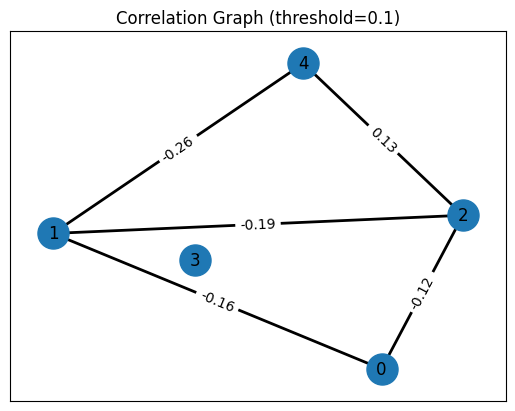

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def construct_correlation_graph(data, method="pearson"):
    """
    Construct a correlation graph from a (V, d, N) dataset.
    
    Parameters:
    data (ndarray): Input dataset of shape (V, d, N), where
                    V: Number of nodes,
                    d: Dimensionality of each observation,
                    N: Number of observations.
    method (str): Correlation method ('pearson' or 'spearman'). Defaults to 'pearson'.
    
    Returns:
    G (networkx.Graph): Correlation graph with nodes representing dataset nodes
                        and edge weights representing correlation.
    """
    V, d, N = data.shape

    # Compute the feature vector for each node (e.g., mean across observations)
    # Shape (V, d*N): each node has a flattened feature vector
    features = data.reshape(V, d * N)

    # Compute pairwise correlation
    if method == "pearson":
        correlation_matrix = np.corrcoef(features)
    else:
        raise ValueError("Only 'pearson' correlation is implemented.")

    # Construct graph
    G = nx.Graph()
    for i in range(V):
        for j in range(i + 1, V):  # Avoid duplicate edges
            weight = correlation_matrix[i, j]
            G.add_edge(i, j, weight=weight)

    return G

def plot_correlation_graph(G, threshold=0.5):
    """
    Plot the correlation graph.
    
    Parameters:
    G (networkx.Graph): Correlation graph.
    threshold (float): Only plot edges with weights above this threshold.
    """
    # Create a layout for the graph
    pos = nx.spring_layout(G)

    # Filter edges by threshold
    edges = [(u, v) for u, v, w in G.edges(data=True) if abs(w['weight']) >= threshold]

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=500)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=2)
    nx.draw_networkx_labels(G, pos)

    # Display weights
    edge_labels = {(u, v): f"{w['weight']:.2f}" for u, v, w in G.edges(data=True) if abs(w['weight']) >= threshold}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title(f"Correlation Graph (threshold={threshold})")
    plt.show()

# Example usage
V, d, N = 5, 3, 10  # 5 nodes, 3D observations, 10 samples
np.random.seed(42)
data = np.random.rand(V, d, N)  # Random dataset

# Construct the correlation graph
G = construct_correlation_graph(data)

# Plot the correlation graph
plot_correlation_graph(G, threshold=0.1)


In [3]:
def RandomSheafSignal(N, V, d, L_f, noisy = False, sigma = 0):
    X = np.random.randn(V*d,N)

    # Tikhonov regularization step
    Lambda, U = np.linalg.eig(L_f)
    H = 1/(1 + 10*Lambda)
    Y = U @ np.diag(H) @ U.T @ X

    Y = np.apply_along_axis(lambda x: x / np.linalg.norm(x), 0, Y)

    if noisy:
        Y += np.random.normal(0, sigma, size=Y.shape)

    return Y

In [13]:
def MapSolver_it(
        d,
        F_u_k, 
        F_v_k, 
        Xu, 
        Xv, 
        beta_u, 
        beta_v, 
        tau):
    
    A11 = np.kron(Xu @ Xu.T, np.eye(d)) - beta_u * np.kron(np.eye(d), F_v_k @ F_v_k.T) + tau * np.eye(d**2)
    A12 = - np.kron(Xu @ Xv.T, np.eye(d))
    A21 = - np.kron(Xv @ Xu.T, np.eye(d))
    A22 = np.kron(Xv @ Xv.T, np.eye(d)) - beta_v * np.kron(np.eye(d), F_u_k @ F_u_k.T) + tau * np.eye(d**2)

    A = np.block([[A11, A12],
                  [A21, A22]])
    
    b = np.block([[(1 / (np.trace(F_u_k @ F_u_k.T)) - tau) * F_u_k.flatten().reshape(-1,1)],
                  [(1 / (np.trace(F_v_k @ F_v_k.T)) - tau) * F_v_k.flatten().reshape(-1,1)]])
    
    sol = np.linalg.solve(A,b)

    Fu = sol[0:d*d,:]
    Fv = sol[d*d:,:]

    return Fu.reshape(d,d), Fv.reshape(d,d)

In [14]:
def MapSolver(
        d,
        Xu, 
        Xv, 
        beta_u, 
        beta_v, 
        tau, 
        gamma = 0.99,
        MAX_ITER = 10,
        tol = 1e-5  # Tolerance for early stopping
):
    
    # Initialization 
    F_u = np.random.randn(d,d)
    F_v = np.random.randn(d,d)

    # Main loop
    for _ in range(MAX_ITER):
        F_u_hat, F_v_hat = MapSolver_it(    
            d,    
            F_u, 
            F_v, 
            Xu, 
            Xv, 
            beta_u, 
            beta_v, 
            tau)
        
        F_u_hat = np.real(F_u_hat)
        F_v_hat = np.real(F_v_hat)

        # Compute the norm of the update for early stopping
        delta_u = np.linalg.norm(F_u_hat - F_u)
        delta_v = np.linalg.norm(F_v_hat - F_v)

        # Early stopping condition
        if delta_u < tol and delta_v < tol:
            break

        # Iterate update
        F_u += gamma * (F_u_hat - F_u)
        F_v += gamma * (F_v_hat - F_v)

        # Stepsize update
        gamma *= (1 - 0.01 * gamma)       

    return F_u, F_v

In [15]:
def SheafSolver(
        Y, 
        V,
        d, 
        beta_u, 
        beta_v, 
        tau, 
        ):
    
    maps = {
        edge: {
            edge[0]:None,
            edge[1]:None
        } for edge in combinations(range(V), 2)
    }

    for e in tqdm(combinations(range(V),2)):
        u = e[0]
        v = e[1]

        Xu = Y[u*d:(u+1)*d,:]
        Xv = Y[v*d:(v+1)*d,:]

        Fu, Fv = MapSolver(        
            d,
            Xu, 
            Xv, 
            beta_u, 
            beta_v, 
            tau,
            gamma = 0.99,
            MAX_ITER = 100
            )

        maps[e][u] = Fu
        maps[e][v] = Fv

    return maps

In [59]:
def DenoisingLaplacianLearning(V, d, edges, Y):
    X = np.copy(Y)
    # Laplacian learning step

    maps_ = SheafSolver(X, V, d, 1, 1, 1)

    E0 = len(edges)
    all_edges = list(combinations(range(V), 2))

    energies = {
        e : 0
        for e in all_edges
        }

    for e in all_edges:
        X_u = X[d*e[0]:(e[0]+1)*d,:]
        X_v = X[d*e[1]:(e[1]+1)*d,:]

        energies[e] = (
            np.linalg.norm(maps_[e][e[0]] @ X_u - maps_[e][e[1]] @ X_v))
        
    retrieved = sorted(energies.items(), key=lambda x:x[1])

    B_hat_2 = np.zeros((d*E0, d*V))

    for i, edge in enumerate([retrieved[i][0] for i in range(E0)]):

        u = edge[0] 
        v = edge[1] 

        B_u = maps_[edge][u]
        B_v = maps_[edge][v]

        B_hat_2[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
        B_hat_2[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    # Sheaf Laplacian

    L_f_hat = B_hat_2.T @ B_hat_2
    L_f_hat /= np.linalg.norm(L_f_hat)

    # Denoising step

    X = np.linalg.inv(np.eye(L_f_hat.shape[0]) + 0.1 * L_f_hat) @ X

    return L_f_hat

In [60]:
def JointDenoiseLaplacianLearning(V, d, edges, Y, MAX_ITER): 
    X = np.copy(Y)
    for _ in range(MAX_ITER):
        # Laplacian learning step

        maps_ = SheafSolver(X, V, d, 1, 1, 1)

        E0 = len(edges)
        all_edges = list(combinations(range(V), 2))

        energies = {
            e : 0
            for e in all_edges
            }

        for e in all_edges:
            X_u = X[d*e[0]:(e[0]+1)*d,:]
            X_v = X[d*e[1]:(e[1]+1)*d,:]

            energies[e] = (
                np.linalg.norm(maps_[e][e[0]] @ X_u - maps_[e][e[1]] @ X_v))
            
        retrieved = sorted(energies.items(), key=lambda x:x[1])

        B_hat_2 = np.zeros((d*E0, d*V))

        for i, edge in enumerate([retrieved[i][0] for i in range(E0)]):

            u = edge[0] 
            v = edge[1] 

            B_u = maps_[edge][u]
            B_v = maps_[edge][v]

            B_hat_2[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
            B_hat_2[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

        # Sheaf Laplacian

        L_f_hat = B_hat_2.T @ B_hat_2
        L_f_hat /= np.linalg.norm(L_f_hat)

        # Denoising step

        X = np.linalg.inv(np.eye(L_f_hat.shape[0]) + 0.1 * L_f_hat) @ X

    return X

In [17]:
V = 32
p = 1.1 * np.log(V)/V
d = 3

L_f, edges = RandomSheaf(V,d,p)
Y = RandomSheafSignal(100, V, d, L_f)
maps_ = SheafSolver(Y, V, d, 1, 10, 10)

496it [00:22, 21.64it/s]


In [18]:
E0 = len(edges)
print(E0)

62


In [19]:
all_edges = list(combinations(range(V), 2))

energies = {
    e : 0
    for e in all_edges
    }

for e in all_edges:
    X_u = Y[d*e[0]:(e[0]+1)*d,:]
    X_v = Y[d*e[1]:(e[1]+1)*d,:]

    energies[e] = (
        np.linalg.norm(maps_[e][e[0]] @ X_u - maps_[e][e[1]] @ X_v))
    
retrieved = sorted(energies.items(), key=lambda x:x[1])

recall = len(set(list(map(lambda x: x[0], retrieved[:E0]))).intersection(set(edges[:E0]))) / E0

TVs = {E:None for E in range(len(list(combinations(range(V),2))))}

for E in range(1, len(list(combinations(range(V),2)))):
    B_hat_2 = np.zeros((d*E, d*V))

    for i, edge in enumerate([retrieved[i][0] for i in range(E)]):

        u = edge[0] 
        v = edge[1] 

        B_u = maps_[edge][u]
        B_v = maps_[edge][v]

        B_hat_2[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
        B_hat_2[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    # Sheaf Laplacian

    L_f_hat_2 = B_hat_2.T @ B_hat_2
    L_f_hat_2 /= np.linalg.norm(L_f_hat_2, ord=2)

    TVs[E] = np.trace(Y.T @ L_f_hat_2 @ Y)

L_f_ = L_f / np.linalg.norm(L_f, ord=2)
TV = np.trace(Y.T @ L_f_ @ Y)

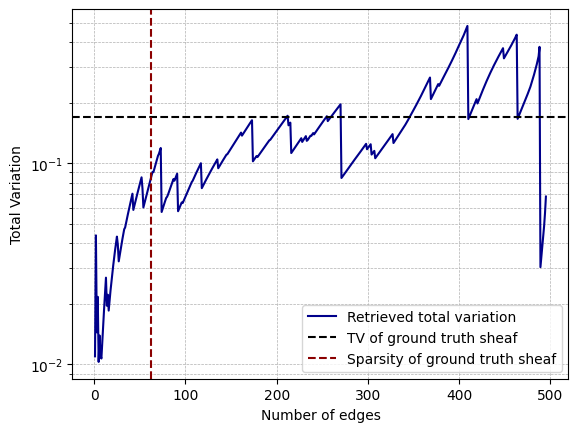

In [20]:
plt.plot(TVs.values(), label='Retrieved total variation', color = 'darkblue')
plt.yscale('log')
plt.xlabel('Number of edges')
plt.ylabel('Total Variation')
plt.axhline(TV, color = 'black', linestyle ='dashed', label = 'TV of ground truth sheaf')
plt.axvline(len(edges), color = 'darkred', linestyle ='dashed', label = 'Sparsity of ground truth sheaf')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [41]:
TVs

{0: None,
 1: 0.03409326596456644,
 2: 0.01970521648611787,
 3: 0.028170434796911382,
 4: 0.034721916843438456,
 5: 0.03842776319781509,
 6: 0.04254892170120994,
 7: 0.050019239140809524,
 8: 0.05297425510248044,
 9: 0.05708437170805096,
 10: 0.06161011818223673,
 11: 0.06195411506781213,
 12: 0.06808856665124367,
 13: 0.06590060872320452,
 14: 0.06964101074166043,
 15: 0.06987793626706194,
 16: 0.07443204678313052,
 17: 0.07698725374853707,
 18: 0.07945192280785363,
 19: 0.08209855731845363,
 20: 0.08538220151967338,
 21: 0.08725509415116749,
 22: 0.08927115840230145,
 23: 0.08718049383867987,
 24: 0.09021368080530703,
 25: 0.09409842622299405,
 26: 0.09788123276895283,
 27: 0.09895718772990533,
 28: 0.0991059547320975,
 29: 0.10073448226791318,
 30: 0.1022705630438535,
 31: 0.10641040985617202,
 32: 0.1092124388995071,
 33: 0.11213725185249063,
 34: 0.11457436567725723,
 35: 0.11791890785186218,
 36: 0.1223588740595492,
 37: 0.1224094843368805,
 38: 0.12422374045919705,
 39: 0.125412

In [16]:
TVs = np.array(list(TVs.values()))

In [34]:
TVs[0] = 0

In [42]:
edges_subset = list(set(list(map(lambda x: x[0], retrieved[:E0]))).intersection(set(edges[:E0])))
edges_hat = list([retrieved[i][0] for i in range(E0)])

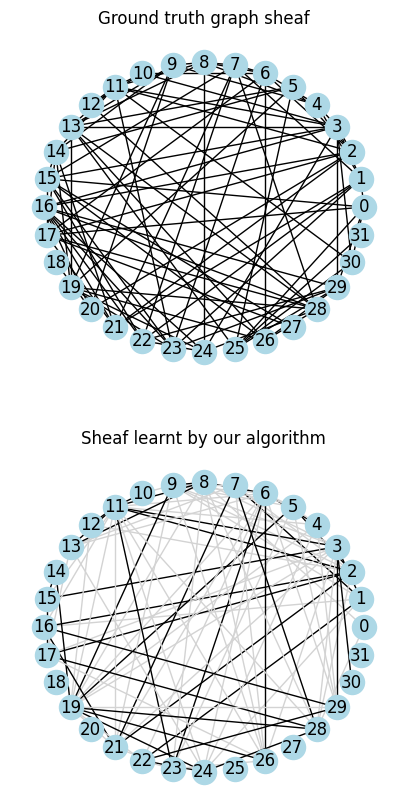

In [43]:
# Define the nodes and edges
nodes = range(V)  # Example nodes

# Create the graphs
G1 = nx.Graph()
G1.add_nodes_from(nodes)
G1.add_edges_from(edges)

G2 = nx.Graph()
G2.add_nodes_from(nodes)
G2.add_edges_from(edges_hat)

# Use the same layout for both graphs
pos = nx.circular_layout(G1)

# Plot the first graph
plt.figure(figsize=(5,10))
plt.subplot(2, 1, 1)
nx.draw(G1, pos, with_labels=True, edge_color="black", node_color="lightblue")
plt.title("Ground truth graph sheaf")

# Plot the second graph with shared edges in red
plt.subplot(2, 1, 2)
edge_colors = ["black" if edge in edges_subset else "lightgray" for edge in G2.edges()]
nx.draw(G2, pos, with_labels=True, edge_color=edge_colors, node_color="lightblue")
plt.title("Sheaf learnt by our algorithm")

plt.show()

In [44]:
B_hat_2 = np.zeros((d*E, d*V))

for i, edge in enumerate([retrieved[i][0] for i in range(E)]):

    u = edge[0] 
    v = edge[1] 

    B_u = maps_[edge][u]
    B_v = maps_[edge][v]

    B_hat_2[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
    B_hat_2[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

# Sheaf Laplacian

L_f_hat_2 = B_hat_2.T @ B_hat_2
L_f_hat_2 /= np.linalg.norm(L_f_hat_2)

In [45]:
np.linalg.norm(L_f - L_f_hat_2)

227.73526443530992

In [46]:
E0

100

In [47]:
recall

0.39

In [48]:
retrieved

[((22, 29), 0.23847996500058202),
 ((19, 22), 0.25541984556145025),
 ((3, 9), 0.2753619813066365),
 ((3, 26), 0.2877630728058289),
 ((11, 13), 0.28864438826812094),
 ((7, 13), 0.30102339997855276),
 ((1, 16), 0.30799378530042487),
 ((11, 16), 0.31085168325502766),
 ((6, 19), 0.3235393169479276),
 ((11, 19), 0.3288939610047109),
 ((6, 13), 0.3301505609646222),
 ((9, 10), 0.3314062133557221),
 ((19, 24), 0.3381854946599811),
 ((3, 11), 0.3419973236428806),
 ((11, 28), 0.34207634593240777),
 ((13, 24), 0.3468491005919551),
 ((17, 26), 0.35137811010820763),
 ((7, 21), 0.35302731723092495),
 ((6, 8), 0.35390344029319576),
 ((7, 28), 0.36062506693433677),
 ((1, 3), 0.3674257899316568),
 ((5, 7), 0.368308654056009),
 ((11, 15), 0.36977686969599993),
 ((5, 6), 0.38182095027300783),
 ((1, 22), 0.39004772065658744),
 ((19, 29), 0.3946077176627477),
 ((6, 26), 0.39551075203651237),
 ((11, 23), 0.3984813793328951),
 ((8, 28), 0.39862955619916723),
 ((7, 9), 0.4028801829896367),
 ((2, 17), 0.409299

In [42]:
B_hat_2 = np.zeros((d*len(edges), d*V))

for i, edge in enumerate([retrieved[i][0] for i in range(E0)]):

    u = edge[0] 
    v = edge[1] 

    B_u = maps_[edge][u]
    B_v = maps_[edge][v]

    B_hat_2[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
    B_hat_2[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

# Sheaf Laplacian

L_f_hat_2 = B_hat_2.T @ B_hat_2

In [27]:
L_f_hat_2 /= np.linalg.norm(L_f_hat_2)

In [28]:
D = np.diag(np.diagonal(L_f_hat_2))
L_f_hat_2 = fractional_matrix_power(D, -0.5) @ L_f_hat_2 @ fractional_matrix_power(D, -0.5)

In [29]:
np.trace(Y.T @ L_f_hat_2 @ Y)

nan

In [24]:
Z = np.zeros((V,V))

In [25]:
for edge in combinations(range(V),2):
    u = edge[0]
    v = edge[1]

    X_u = Y[u*d:(u+1)*d,:]
    X_v = Y[v*d:(v+1)*d,:]

    Fu = maps_[edge][u]
    Fv = maps_[edge][v]
    Z[u,v] = np.linalg.norm(Fu @ X_u - Fv @ X_v)
    Z[v,u] = np.linalg.norm(Fu @ X_u - Fv @ X_v)

In [26]:
def Kalofolias_Optimization(Z, alpha, beta, n):
    # Define the variable
    W = cp.Variable((n, n), symmetric=True)

    # Constraints: diagonal elements must be zero
    constraints = [cp.diag(W) == 0]

    # Objective function components
    term1 = cp.norm1(cp.multiply(W, Z))  # ||W ∘ Z||_1,1
    term2 = -alpha * cp.sum(cp.log(cp.sum(W, axis=1)))  # -α * 1^T log(W1)
    term3 = (beta / 2) * cp.norm(W, 'fro')**2  # (β/2) * ||W||_F^2

    # Define the objective
    objective = cp.Minimize(term1 + term2 + term3)

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve()

    # Return the optimal solution
    return W.value

In [ ]:
alpha = [0.001,0.005,0.01,0.5,1,5]
beta = [0.001,0.005,0.01,0.5,1,5]

for alpha_ in alpha:
    for beta_ in beta:
        W = Kalofolias_Optimization(Z,alpha_, beta_, V)

        for u in range(V):
            for v in range(u,V):
                if W[u,v] < 1e-5:
                    W[u,v] = 0
                    W[v,u] = 0

        retrieved_edges = []

        for u in range(V):
            for v in range(u,V):
                if W[u,v] != 0:
                    retrieved_edges.append((u,v))

        print(alpha_, beta_, len(set(retrieved_edges).intersection(set(edges))) / len(retrieved_edges))

In [ ]:
# Define optimization variables
M = {}
for i in range(V):
    for j in range(i, V):
        M[(i, j)] = cp.Variable((V*d, V*d), symmetric=True)

# Define L as a new variable and add constraints
L = cp.Variable((V*d, V*d), symmetric=True)
constraints = [L == sum(M[(i, j)] for i in range(V) for j in range(i, V))]

# Ensure positive semi-definiteness and structure of M_ij
for i in range(V):
    for j in range(i, V):
        M_ij = M[(i, j)]
        constraints.append(M_ij >> 0)  # M_ij is positive semi-definite
        if i != j:  # Enforce structural zeros for off-block elements in M_ij
            M_block = M_ij[i*d:(i+1)*d, j*d:(j+1)*d]
            constraints.append(M_block == 0)

# Define penalties
penalty1 = -cp.sum([cp.log(cp.trace(M[(i, i)])) for i in range(V)])
penalty2 = cp.sum([cp.norm(M[(i, j)], 'fro') for i in range(V) for j in range(i + 1, V)])

# Define objective
objective = cp.Minimize(cp.trace(Y.T @ L @ Y) + penalty1 + penalty2)

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve(solver='MOSEK')

# Output results
print("Optimal value:", problem.value)
print("Optimal L:", L.value)
